In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle competitions download -c quora-question-pairs

 96% 297M/309M [00:03<00:00, 151MB/s]
100% 309M/309M [00:03<00:00, 101MB/s]


In [6]:
import zipfile
zip_ref= zipfile.ZipFile('quora-question-pairs.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [8]:
import zipfile
zip_ref= zipfile.ZipFile('train.csv.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
df = pd.read_csv('train.csv')

In [9]:
df.shape

(404290, 6)

In [10]:
new_df = df.sample(50000,random_state=2)

In [11]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [13]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('&', ' and ')
    q = q.replace('£', ' pounds')


    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    #Remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    q = re.sub(url_pattern, ' ', q).strip()


    return q


In [14]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [15]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [16]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


In [17]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [18]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [19]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [20]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [21]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [22]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [23]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


In [24]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [25]:
import nltk
nltk.download('stopwords')
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0


In [29]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=cb2f2c324dd92d568f19a207b4c973d8c83b56bc2fa92a1b33e842b3cf3b0197
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [30]:
import distance

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features


In [31]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [32]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.499988,0.714276,0.624992,0.583328,0.466664,1.0,1.0,3.0,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.000000,0.428565,0.272725,0.149999,0.115384,0.0,0.0,6.0,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,0.000000,0.000000,0.599988,0.333330,1.0,0.0,4.0,7.0,0.542857


In [34]:
!pip install fuzzywuzzy

In [35]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [36]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [37]:
print(new_df.shape)
new_df.head()

(50000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


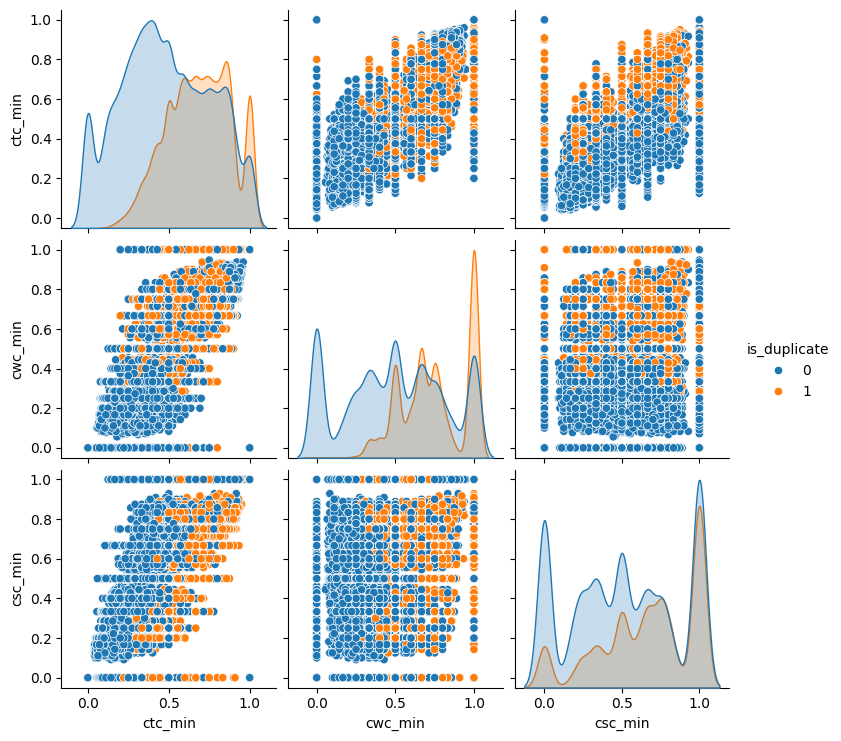

In [38]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

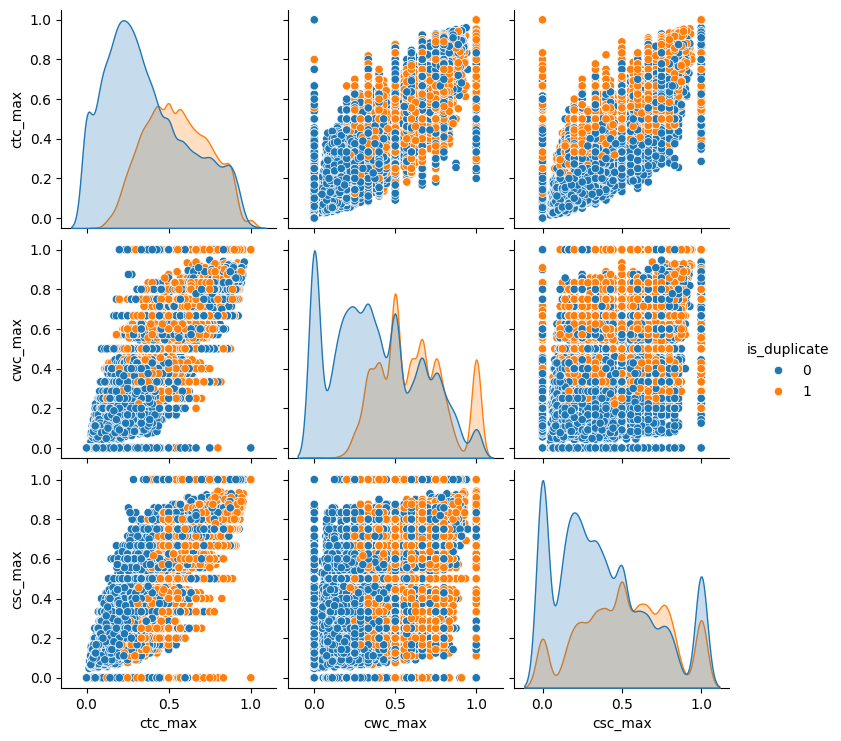

In [39]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

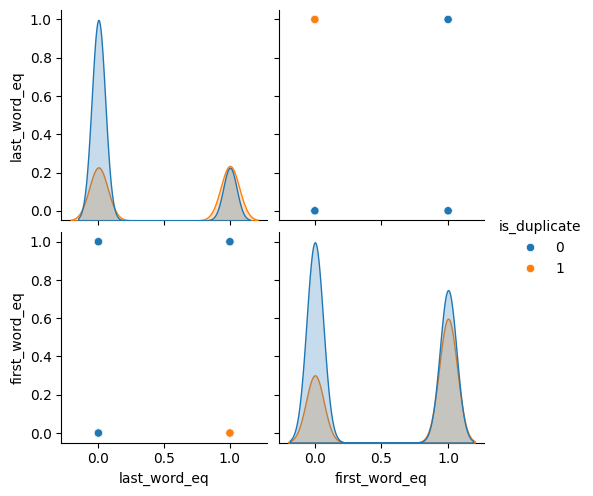

In [40]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

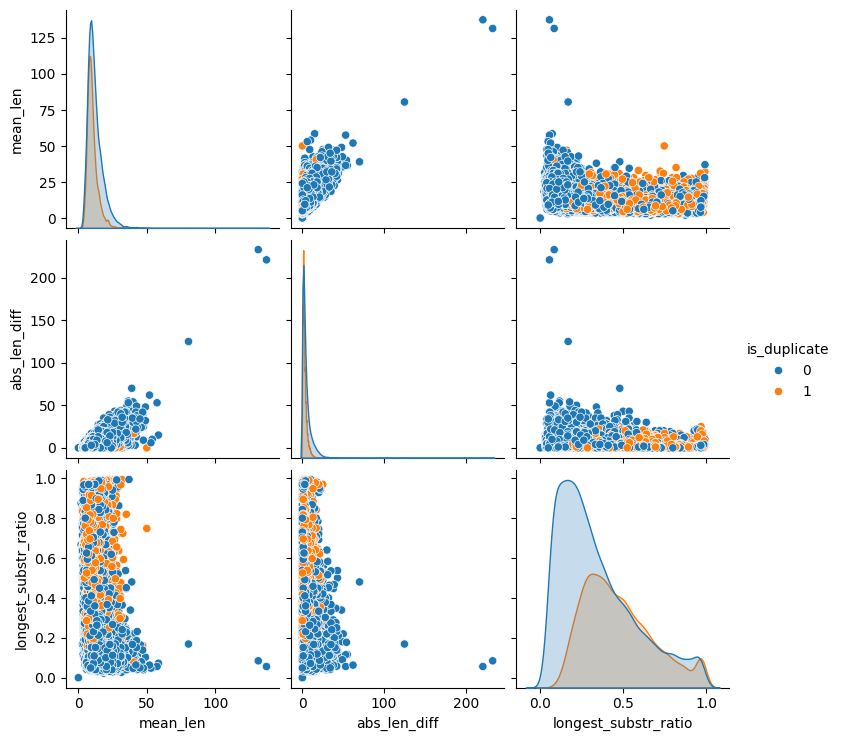

In [41]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

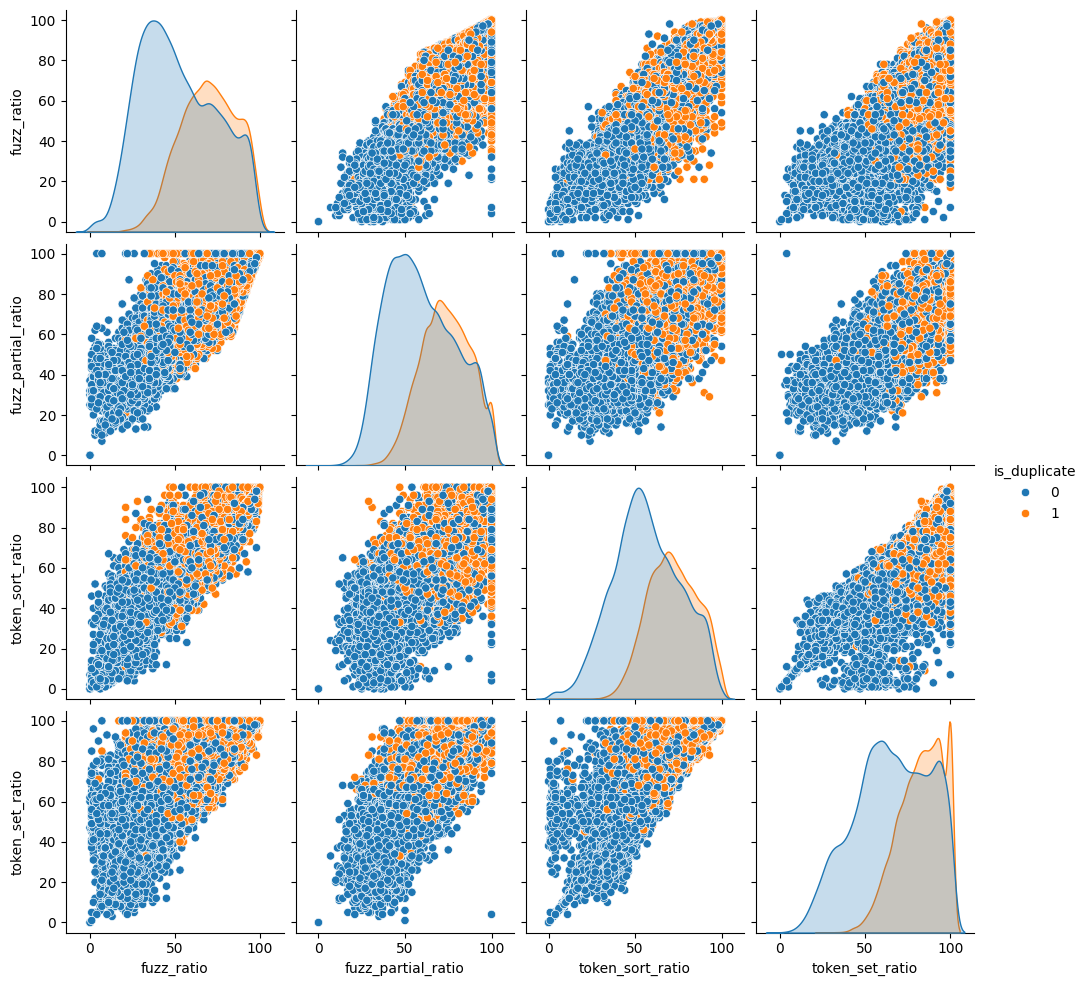

In [42]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [43]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [44]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.101s...
[t-SNE] Computed neighbors for 50000 samples in 14.632s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [45]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [46]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0.466664,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.115384,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.333330,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


In [47]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [48]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(50000, 6000)

In [49]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(50000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0,0,1,0,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.794

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.795

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[5437,  848],
       [1212, 2503]])

In [55]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[5344,  941],
       [1109, 2606]])

In [56]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)

In [57]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return (len(w1) + len(w2))

In [58]:
def test_fetch_token_features(q1,q2):

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [59]:
def test_fetch_length_features(q1,q2):

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [60]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [61]:
def query_point_creator(q1,q2):

    input_query = []

    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))

    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)

    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()

    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()



    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [62]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of IIndia?'

In [63]:
rf.predict(query_point_creator(q1,q4))

array([0])

In [64]:
cv

CountVectorizer(max_features=3000)

In [65]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))